In [ ]:
import pandas as pd 
import numpy as np


<h1>Loading Dataset</h1>

In [ ]:
movies=pd.read_csv('movies_metadata.csv')
credits=pd.read_csv('credits.csv')
keywords=pd.read_csv('keywords.csv')
ratings=pd.read_csv('ratings_small.csv')

In [ ]:
movies.head(1)

In [ ]:
credits.head(1)

In [ ]:
keywords.head(1)

In [ ]:
ratings.head(1)

<h1>Merging Dataset</h1>

In [ ]:
# Fix 'id' column types for proper merging
# Remove non-numeric IDs and convert to integers
movies = movies[movies['id'].apply(lambda x: str(x).isdigit())].copy()
movies['id'] = movies['id'].astype(int)
credits['id'] = credits['id'].astype(int)
keywords['id'] = keywords['id'].astype(int)

# Merge movies with credits
movies_merged = movies.merge(credits, on='id')

# Merge the result with keywords
final_merged = movies_merged.merge(keywords, on='id')

# final_merged now contains combined information from all three datasets
final_merged.head()
final_merged.head(1)


In [ ]:
# CONTENT BASED
#1.genres
#2.id
#3.overview
#4.title
#5.cast
#6.crew
#7.keywords

<h1>Selecting Column</h1>

In [ ]:
final_merged=final_merged[['id','title','overview','genres','keywords','cast','crew']]

In [ ]:
final_merged.head(1)

<h1>Preprocessing</h1>

In [ ]:
final_merged.dropna(inplace=True)

In [ ]:
final_merged.isnull().sum()

In [ ]:
# remove duplicated data
final_merged = final_merged.drop_duplicates()

In [ ]:
# check duplicated data
final_merged.duplicated().sum()

In [ ]:
final_merged.iloc[0].genres

In [ ]:
import ast
ast.literal_eval

In [ ]:
import ast

def convert(obj):
    try:
        parsed = ast.literal_eval(obj)
        return [item['name'] for item in parsed if 'name' in item]
    except (ValueError, SyntaxError):
        return []  


In [ ]:
final_merged['genres']=final_merged['genres'].apply(convert)

In [ ]:
final_merged.head(1)

In [ ]:
final_merged['keywords']=final_merged['keywords'].apply(convert)

In [ ]:
final_merged.head(1)

In [ ]:
final_merged.iloc[1]

In [ ]:
final_merged.head(1)

In [ ]:
import ast

def convert3(obj):
    L = []
    counter = 0  # Initialize counter
    try:
        for i in ast.literal_eval(obj):
            if counter != 3:
                L.append(i['name'])
                counter += 1
            else:
                break
    except (ValueError, SyntaxError):
        pass  # In case the string is not valid
    return L


In [ ]:
final_merged['cast']=final_merged['cast'].apply(convert)

In [ ]:
final_merged.head(1)

In [ ]:
import ast

def fetch_director(obj):
    try:
        for i in ast.literal_eval(obj):
            if i.get('job') == 'Director':
                return [i.get('name')]
    except (ValueError, SyntaxError):
        pass
    return []


In [ ]:
final_merged['crew']=final_merged['crew'].apply(fetch_director)

In [ ]:
final_merged.head(1)

In [ ]:
final_merged['overview'][0]

In [ ]:
final_merged['overview'] = final_merged['overview'].apply(lambda x: x.split() if isinstance(x, str) else x)


In [ ]:
final_merged.head(1)

<h1>Transformation</h1>

In [ ]:
final_merged.head(5)

In [ ]:
def remove_spaces(lst):
    return [i.replace(" ", "") for i in lst if isinstance(i, str)]
    s

final_merged['genres'] = final_merged['genres'].apply(remove_spaces)
final_merged['keywords'] = final_merged['keywords'].apply(remove_spaces)
final_merged['cast'] = final_merged['cast'].apply(remove_spaces)
final_merged['crew'] = final_merged['crew'].apply(remove_spaces)


In [ ]:
final_merged.head(1)

In [ ]:
# new column(overview+genres+keywords+cast+crew=tags)

final_merged['tags']=final_merged['overview'] + final_merged['genres'] + final_merged['keywords'] + final_merged['cast'] + final_merged['crew']

In [ ]:
final_merged.head()

In [ ]:
final_merged=final_merged[['id','title','tags']]

In [ ]:
final_merged.head()

In [ ]:
final_merged['tags']=final_merged['tags'].apply(lambda x:" ".join(x))

In [ ]:
final_merged.head()

In [ ]:
final_merged['tags'][1]

<h1>Collaborative filtering</h1>

<h1>Impoting</h1>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Load dataset</h1>

In [4]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
ratings = pd.read_csv('ratings_small.csv')
links = pd.read_csv('links_small.csv')

<h1>Understand the data</h1>

In [5]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


In [11]:
movies.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [12]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [13]:
links.describe()

,movieId,imdbId,tmdbId
count,9125.000000,9.125000e+03,9112.000000
mean,31123.291836,4.798244e+05,39104.545544
std,40782.633604,7.431774e+05,62814.519801
min,1.000000,4.170000e+02,2.000000
25%,2850.000000,8.884600e+04,9451.750000
50%,6290.000000,1.197780e+05,15852.000000
75%,56274.000000,4.284410e+05,39160.500000
max,164979.000000,5.794766e+06,416437.000000


In [14]:
#checking shape
print(movies.shape)
print(ratings.shape)
print(links.shape)

(45466, 24)
(100004, 4)
(9125, 3)


<h1>checking missing values</h1>

In [15]:
#fix missing values
movies.dropna(inplace=True)

In [16]:
#checking missing values
movies.isnull().sum()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
id                       0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
dtype: int64

In [17]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [18]:
links.isnull().sum()

movieId     0
imdbId      0
tmdbId     13
dtype: int64

<h1>checking duplicated</h1>

In [19]:
movies.duplicated().sum()

0

In [20]:
ratings.duplicated().sum()

0

In [21]:
links.duplicated().sum()

0


<h1>Merging dataset</h1>

In [22]:
# Convert movieId to int
ratings['movieId'] = ratings['movieId'].astype(int)
links['movieId'] = links['movieId'].astype(int)

In [23]:
# Convert tmdbId and id safely to numeric
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce').astype('Int64')
movies['id'] = pd.to_numeric(movies['id'], errors='coerce').astype('Int64')

In [24]:
# Merge ratings with links
ratings_links = pd.merge(ratings, links, on='movieId', how='left')

In [25]:
# Merge with movies metadata
merged = pd.merge(ratings_links, movies, left_on='tmdbId', right_on='id', how='left')

In [26]:
# Check how many titles are missing
missing_titles = merged['title'].isna().sum()
print(f"Missing titles: {missing_titles} out of {len(merged)}")

Missing titles: 87006 out of 100005


In [27]:
# Drop rows where tmdbId is missing
ratings_links_clean = ratings_links.dropna(subset=['tmdbId'])

# Drop rows where id is missing in movies
movies_clean = movies.dropna(subset=['id'])

# Merge again
merged_clean = pd.merge(ratings_links_clean, movies_clean, left_on='tmdbId', right_on='id', how='left')


In [28]:
final_data = merged_clean[['userId', 'movieId', 'rating', 'title']].dropna(subset=['title'])


In [29]:
final_data

,userId,movieId,rating,title
3,1,1129,2.0,Escape from New York
20,2,10,4.0,GoldenEye
38,2,223,1.0,Clerks
59,2,364,3.0,The Lion King
72,2,480,4.0,Jurassic Park
...,...,...,...,...
99910,671,4963,4.5,Ocean's Eleven
99912,671,4993,5.0,The Lord of the Rings: The Fellowship of the Ring
99915,671,5218,2.0,Ice Age
99917,671,5349,4.0,Spider-Man


<h1>Ratings Distribution Visualization</h1>

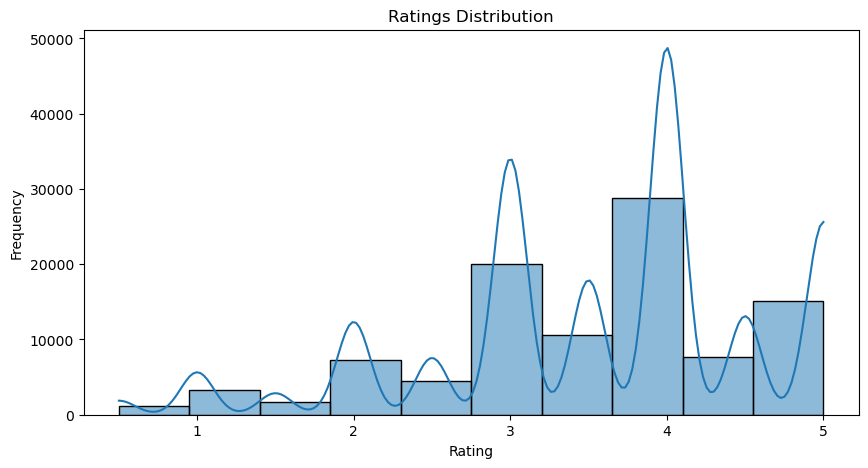

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


<h1>Create User-Movie Matrix</h1>

In [31]:
user_movie_matrix = merged.pivot_table(index='userId', columns='title', values='rating')


In [32]:
user_movie_matrix 

title,2046,21 Jump Street,22 Jump Street,30 Days of Night,300,300: Rise of an Empire,A Cinderella Story,A Close Shave,A Good Day to Die Hard,A Matter of Loaf and Death,...,Wreck-It Ralph,X-Men Origins: Wolverine,X-Men: Apocalypse,X-Men: Days of Future Past,X-Men: First Class,You Only Live Twice,Zoolander 2,[REC],xXx,xXx: State of the Union
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h1>Compute Similarity Matrix (User-Based CF)</h1>

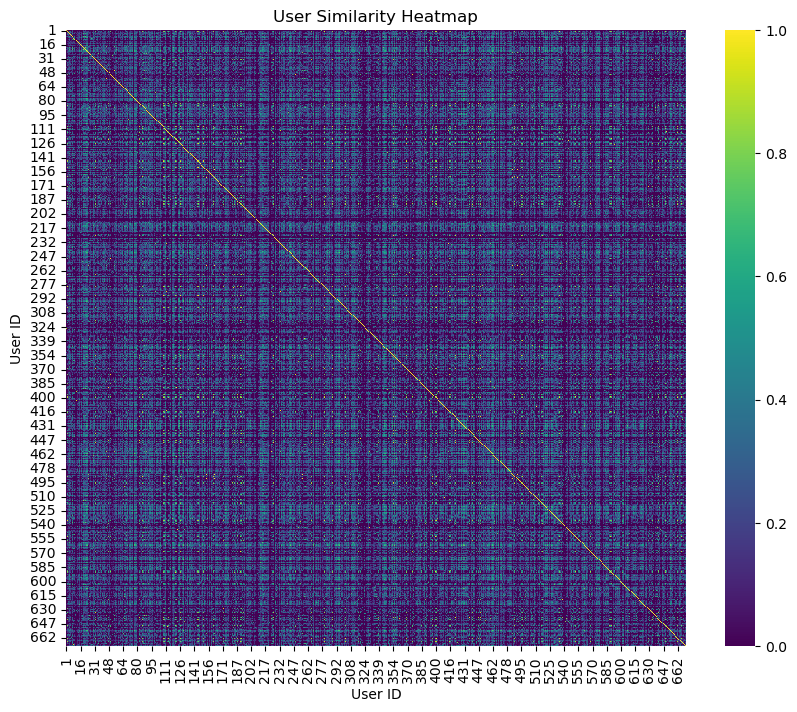

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_movie_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Heatmap of User Similarity
plt.figure(figsize=(10, 8))
sns.heatmap(user_similarity_df, cmap='viridis')
plt.title('User Similarity Heatmap')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()


<h1>Recommend Movies for a User</h1>

In [34]:
# Get movies rated by user 1
user_id = 1
user_ratings = user_movie_matrix.loc[user_id]

# Find similar users
similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6]  # top 5 similar users

# Weighted average ratings from similar users
recommendation_scores = user_movie_matrix.loc[similar_users.index].mean()

# Remove movies already rated
recommendation_scores = recommendation_scores[~user_ratings.notna()]

# Top 10 recommendations
top_recommendations = recommendation_scores.sort_values(ascending=False).head(10)

# Display
print("Top Movie Recommendations for User 1:")
print(top_recommendations)


Top Movie Recommendations for User 1:
title
Alien                                                5.0
From Russia with Love                                5.0
The Matrix                                           5.0
The Lord of the Rings: The Fellowship of the Ring    5.0
The Godfather                                        5.0
Raiders of the Lost Ark                              5.0
Planet of the Apes                                   5.0
Back to the Future                                   5.0
The Terminator                                       5.0
Blade Runner                                         5.0
dtype: float64


<h1> Visualize Top Recommendations</h1>

C:\Users\Hp\AppData\Local\Temp\ipykernel_9568\3532314745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_recommendations.values, y=top_recommendations.index, palette='coolwarm')


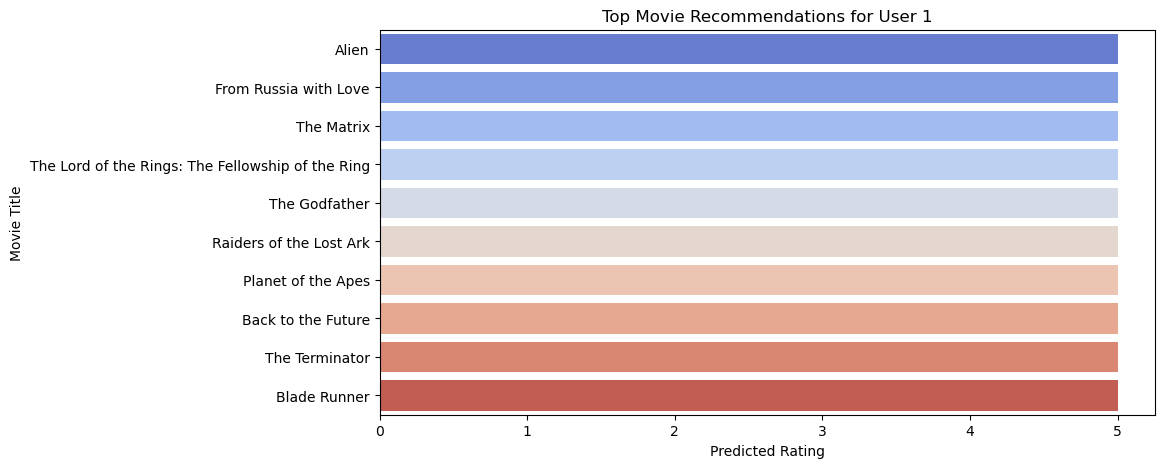

In [35]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_recommendations.values, y=top_recommendations.index, palette='coolwarm')
plt.title('Top Movie Recommendations for User 1')
plt.xlabel('Predicted Rating')
plt.ylabel('Movie Title')
plt.show()


<h1>Item-Based Collaborative Filtering + Visualization</h1>

In [36]:
# create User-Movie Ratings Matrix
user_movie_matrix = merged.pivot_table(index='userId', columns='title', values='rating')


In [37]:
user_movie_matrix

title,2046,21 Jump Street,22 Jump Street,30 Days of Night,300,300: Rise of an Empire,A Cinderella Story,A Close Shave,A Good Day to Die Hard,A Matter of Loaf and Death,...,Wreck-It Ralph,X-Men Origins: Wolverine,X-Men: Apocalypse,X-Men: Days of Future Past,X-Men: First Class,You Only Live Twice,Zoolander 2,[REC],xXx,xXx: State of the Union
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Compute Movie Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity

# Fill NaN with 0 (unrated movies)
movie_similarity = cosine_similarity(user_movie_matrix.T.fillna(0))
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Heatmap of similarity (top 20 popular movies only for clarity)
top_movies = ratings['movieId'].value_counts().head(20).index
top_titles = merged[merged['movieId'].isin(top_movies)]['title'].unique()
similarity_sample = movie_similarity_df.loc[top_titles, top_titles]

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_sample, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Movie-to-Movie Similarity Heatmap (Top 20)')
plt.show()


KeyError: '[nan] not in index'

In [ ]:
#Recommend Similar Movies to a Given Title
def get_similar_movies(movie_name, top_n=10):
    if movie_name not in movie_similarity_df.columns:
        print(f"Movie '{movie_name}' not found.")
        return
    similar_scores = movie_similarity_df[movie_name].sort_values(ascending=False)[1:top_n+1]
    return similar_scores

# Example: Recommend movies similar to "Toy Story (1995)"
recommendations = get_similar_movies("Toy Story (1995)")
print("Movies similar to Toy Story (1995):")
print(recommendations)


In [ ]:
#. Visualize Recommendations
# Barplot of recommended similar movies
plt.figure(figsize=(10,6))
sns.barplot(x=recommendations.values, y=recommendations.index, palette='viridis')
plt.title('Top Movies Similar to "Toy Story (1995)"')
plt.xlabel('Similarity Score')
plt.ylabel('Movie Title')
plt.show()


In [ ]:
final_data.head()

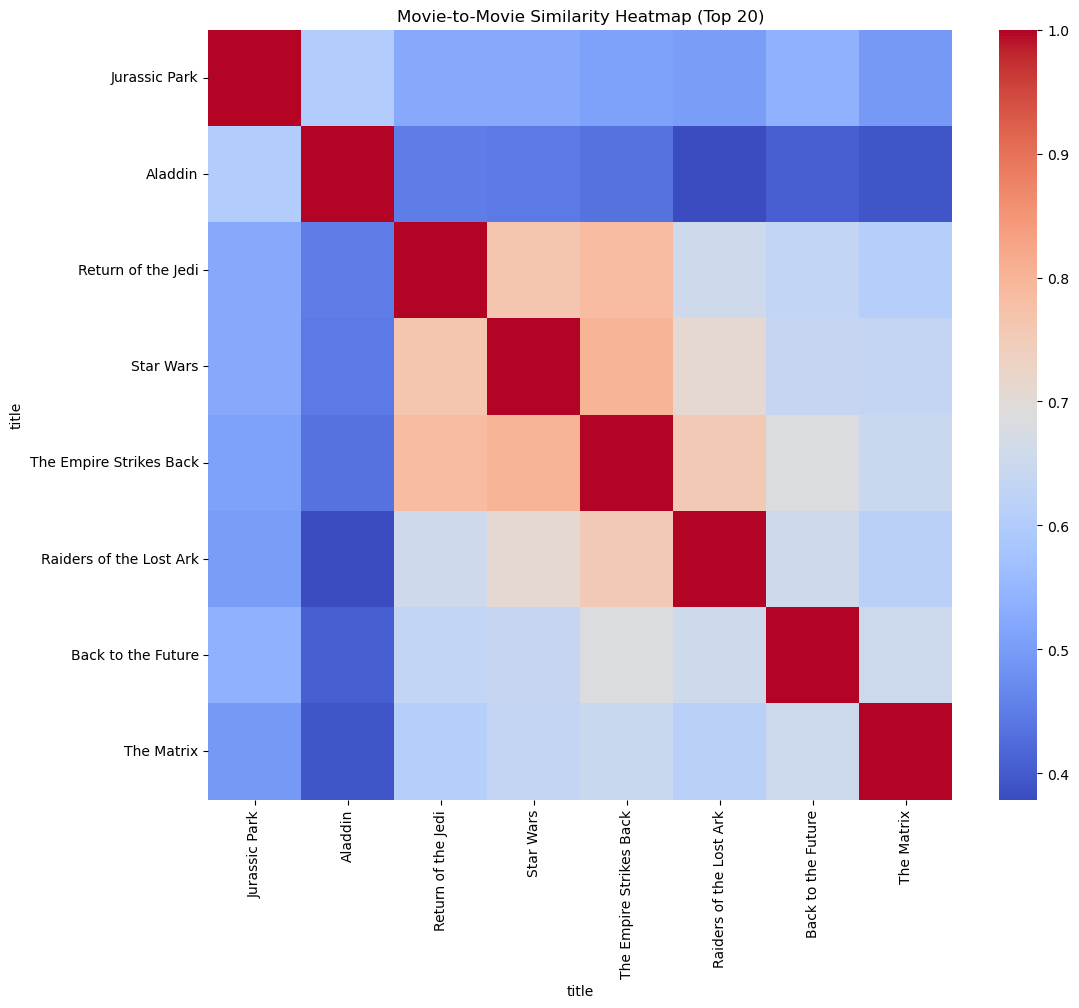

In [39]:
# Filter out NaN and ensure titles are in the similarity matrix
top_movies = ratings['movieId'].value_counts().head(20).index
top_titles = merged[merged['movieId'].isin(top_movies)]['title'].dropna().unique()

# Filter titles that actually exist in the similarity matrix
valid_top_titles = [title for title in top_titles if title in movie_similarity_df.index]

# Subset similarity matrix
similarity_sample = movie_similarity_df.loc[valid_top_titles, valid_top_titles]

plt.figure(figsize=(12, 10))
sns.heatmap(similarity_sample, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Movie-to-Movie Similarity Heatmap (Top 20)')
plt.show()


In [40]:
print(user_movie_matrix.columns[:10])  # Show first 10 movie titles


Index(['2046', '21 Jump Street', '22 Jump Street', '30 Days of Night', '300',
       '300: Rise of an Empire', 'A Cinderella Story', 'A Close Shave',
       'A Good Day to Die Hard', 'A Matter of Loaf and Death'],
      dtype='object', name='title')


In [41]:
print([col for col in user_movie_matrix.columns if "toy story" in col.lower()])


['Toy Story 2', 'Toy Story 3']


In [42]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches

# Assuming user_movie_matrix is already created and filled with ratings
# Replace NaNs with 0s to compute similarity
movie_similarity = cosine_similarity(user_movie_matrix.T.fillna(0))
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Define function to recommend similar movies
def get_similar_movies(movie_name, top_n=10):
    # Try to find the closest match
    matches = get_close_matches(movie_name, movie_similarity_df.columns, n=1, cutoff=0.6)
    
    if not matches:
        print(f"Movie '{movie_name}' not found in dataset.")
        return None
    
    matched_name = matches[0]
    print(f"Matched your input to: '{matched_name}'")
    
    similar_scores = movie_similarity_df[matched_name].sort_values(ascending=False)[1:top_n+1]
    return similar_scores

# Ask user for a movie and show recommendations
while True:
    user_input = input("\nEnter a movie name (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    recommendations = get_similar_movies(user_input)
    if recommendations is not None:
        print("\nTop Recommendations:")
        for movie, score in recommendations.items():
            print(f"{movie} (Similarity Score: {score:.2f})")



Enter a movie name (or type 'exit' to quit):  avatar


Matched your input to: 'Avatar'

Top Recommendations:
Iron Man (Similarity Score: 0.63)
The Dark Knight (Similarity Score: 0.58)
Sherlock Holmes (Similarity Score: 0.56)
The Dark Knight Rises (Similarity Score: 0.55)
The Avengers (Similarity Score: 0.53)
The Hangover (Similarity Score: 0.53)
How to Train Your Dragon (Similarity Score: 0.52)
Guardians of the Galaxy (Similarity Score: 0.52)
300 (Similarity Score: 0.51)
Sherlock Holmes: A Game of Shadows (Similarity Score: 0.51)



Enter a movie name (or type 'exit' to quit):  averange


Movie 'averange' not found in dataset.



Enter a movie name (or type 'exit' to quit):  spiderman


Matched your input to: 'Spider-Man'

Top Recommendations:
Spider-Man 2 (Similarity Score: 0.69)
Pirates of the Caribbean: The Curse of the Black Pearl (Similarity Score: 0.66)
The Lord of the Rings: The Two Towers (Similarity Score: 0.66)
Ocean's Eleven (Similarity Score: 0.65)
The Lord of the Rings: The Fellowship of the Ring (Similarity Score: 0.65)
Shrek (Similarity Score: 0.63)
The Lord of the Rings: The Return of the King (Similarity Score: 0.63)
Finding Nemo (Similarity Score: 0.59)
The Incredibles (Similarity Score: 0.59)
The Bourne Identity (Similarity Score: 0.58)


KeyboardInterrupt: Interrupted by user